# Training a stack of dynamical layers

## Imports and housekeeping

In [1]:
# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

# - Rockpool imports
from rockpool import TSContinuous

# -  Other imports
import numpy as np
from tqdm.autonotebook import tqdm

# - Configure matplotlib
import pylab as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

No module named 'rpyc'
No module named 'rpyc'
No module named 'rpyc'


## Building a stack

In [2]:
# - Import the individual layer classes
from rockpool.layers import FFRateEulerJax, RecRateEulerJax_IO

# - Import the JaxStack network class
from rockpool.networks import JaxStack

Let's define the network architecture for a stack of feed-forward layers. We'll define a list of layer sizes, including input and output dimensionality (`layer_sizes`). We'll use a common initial time constant $\tau$ (`tau`) and biases `bias`. We also need to define the time-step $\textrm{d}t$ (`dt`) for each layer. It's easiest if this is a common value.

In [3]:
# - Define a feed-forward network architecture
layer_sizes = [1, 10, 5, 1]

# - Define common layer parameters
tau = 100e-3
bias = 0.
dt = 1e-3

This will construct the following network architecture:

In [4]:
from IPython.display import Image
Image(filename='images/ffwd_stack_1_10_5_1.png', width=200)

In [5]:
# - Iterate over layers and construct them into a list
layers = []
for N_in, N_out in zip(layer_sizes[:-1], layer_sizes[1:]):
    # - Generate random parameters for this layer
    weights = np.random.randn(N_in, N_out) / np.sqrt(N_in * N_out)

    # - Build a layer and append it to the list
    layers.append(FFRateEulerJax(weights, tau, bias, dt = dt))

In [6]:
# - Import the JaxStack class
from rockpool.networks import JaxStack

stack_ffwd = JaxStack(layers)
print(stack_ffwd)

JaxStack object with 3 layers
    FFRateEulerJax object: "unnamed" [1 TSContinuous in -> 10 internal -> 10 TSContinuous out]
    FFRateEulerJax object: "unnamed_0" [10 TSContinuous in -> 5 internal -> 5 TSContinuous out]
    FFRateEulerJax object: "unnamed_1" [5 TSContinuous in -> 1 internal -> 1 TSContinuous out]


## Evolving a stack

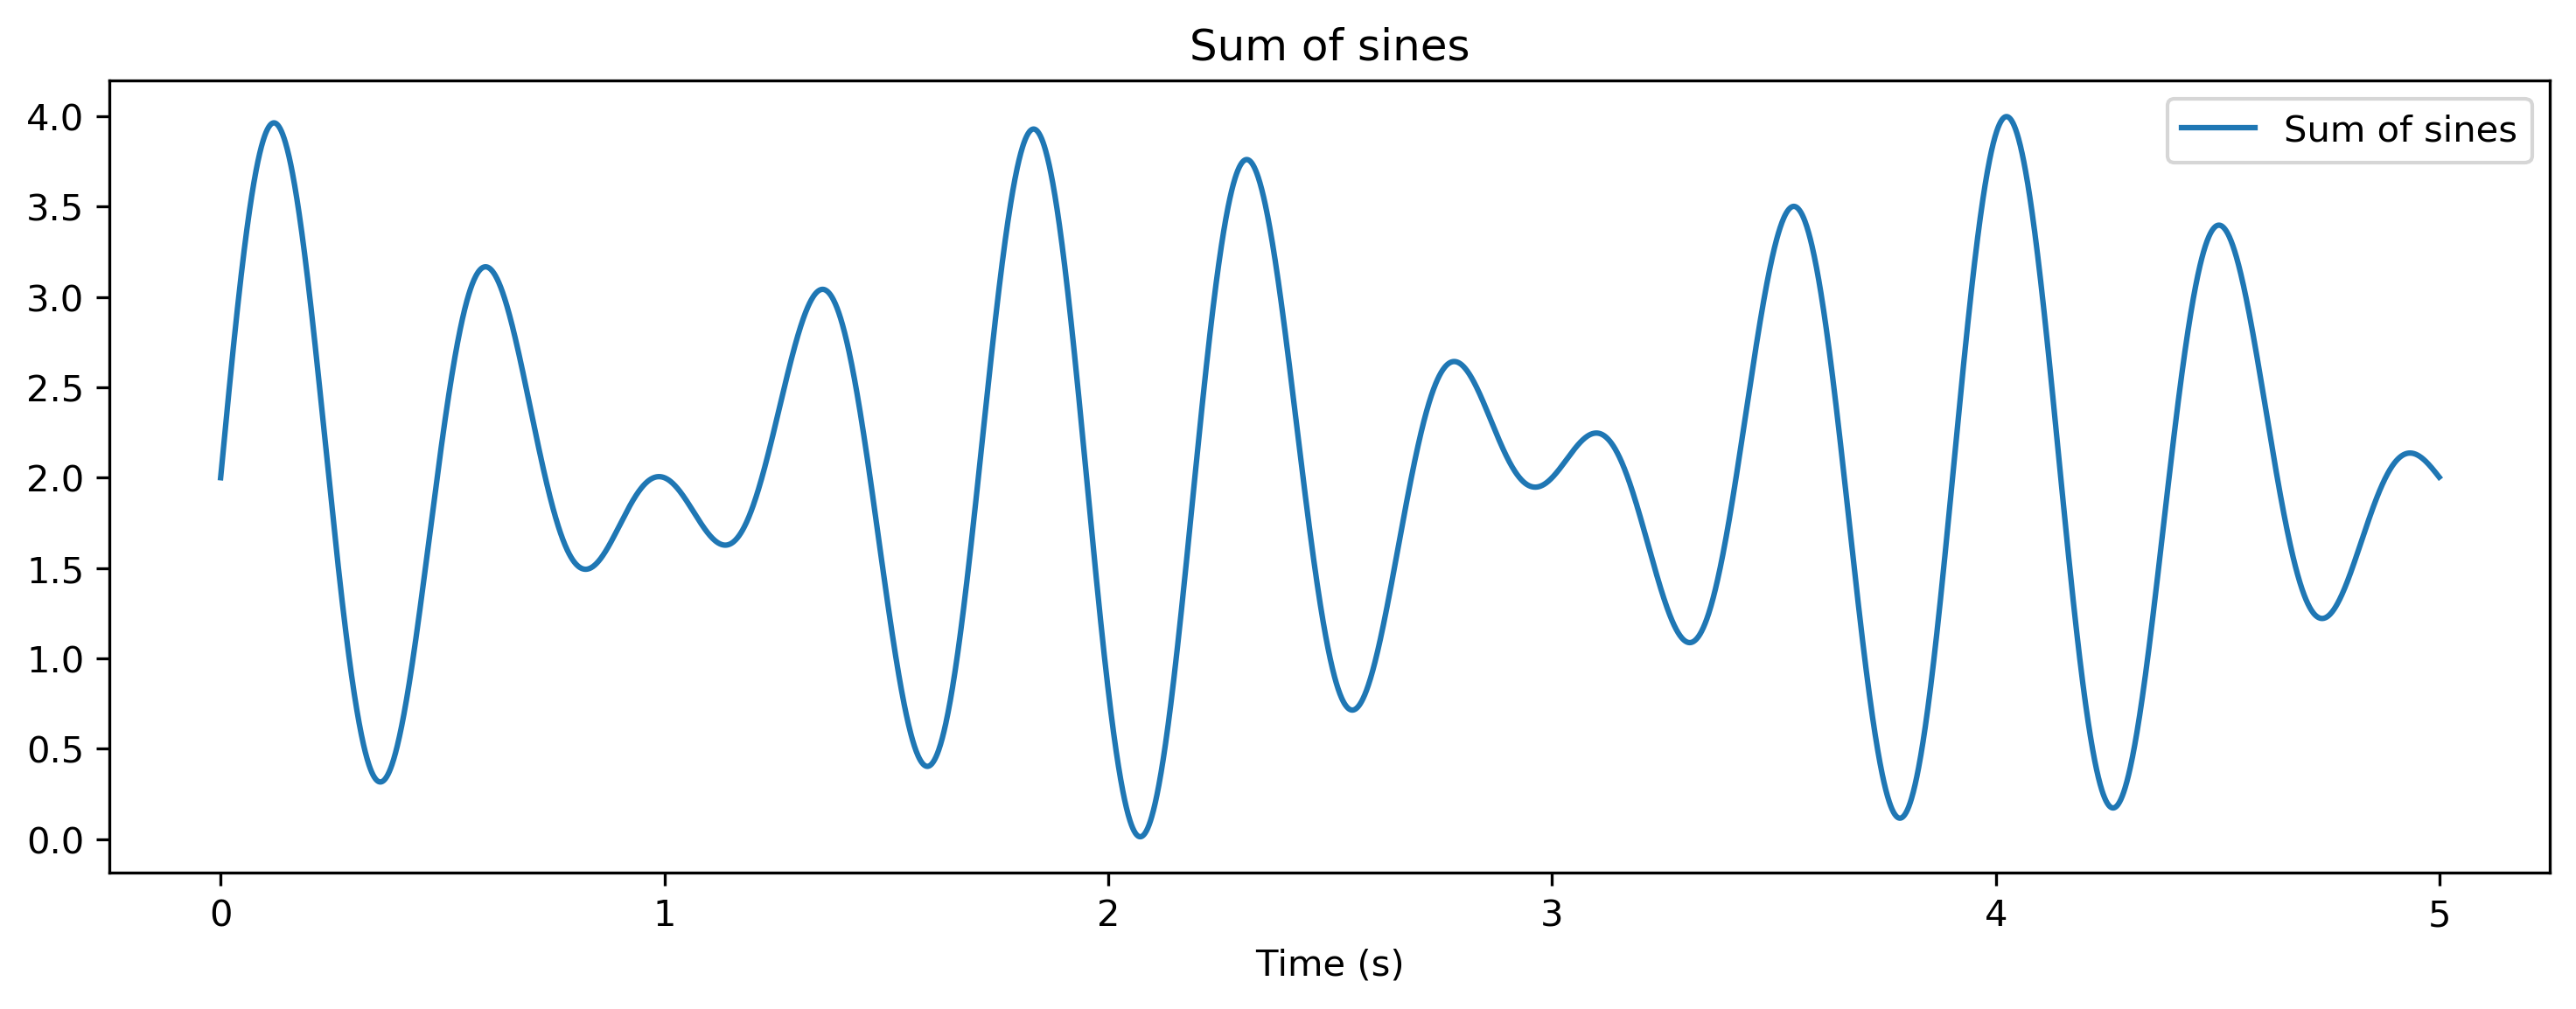

In [7]:
# - Set the duration of the signals, in seconds
duration = 5
frequency_low = 1.8
frequency_high = 2.3

# - Define a time base for the signal
time_base = np.arange(0, duration, dt)

# - Define a periodic sinusoidal signal
ts_sinusoid = TSContinuous(time_base,
                           np.sin(time_base * 2*np.pi * frequency_low) + np.sin(time_base * 2*np.pi * frequency_high) + 2,
                           periodic=True, name = 'Sum of sines')
ts_sinusoid.plot()
plt.legend();

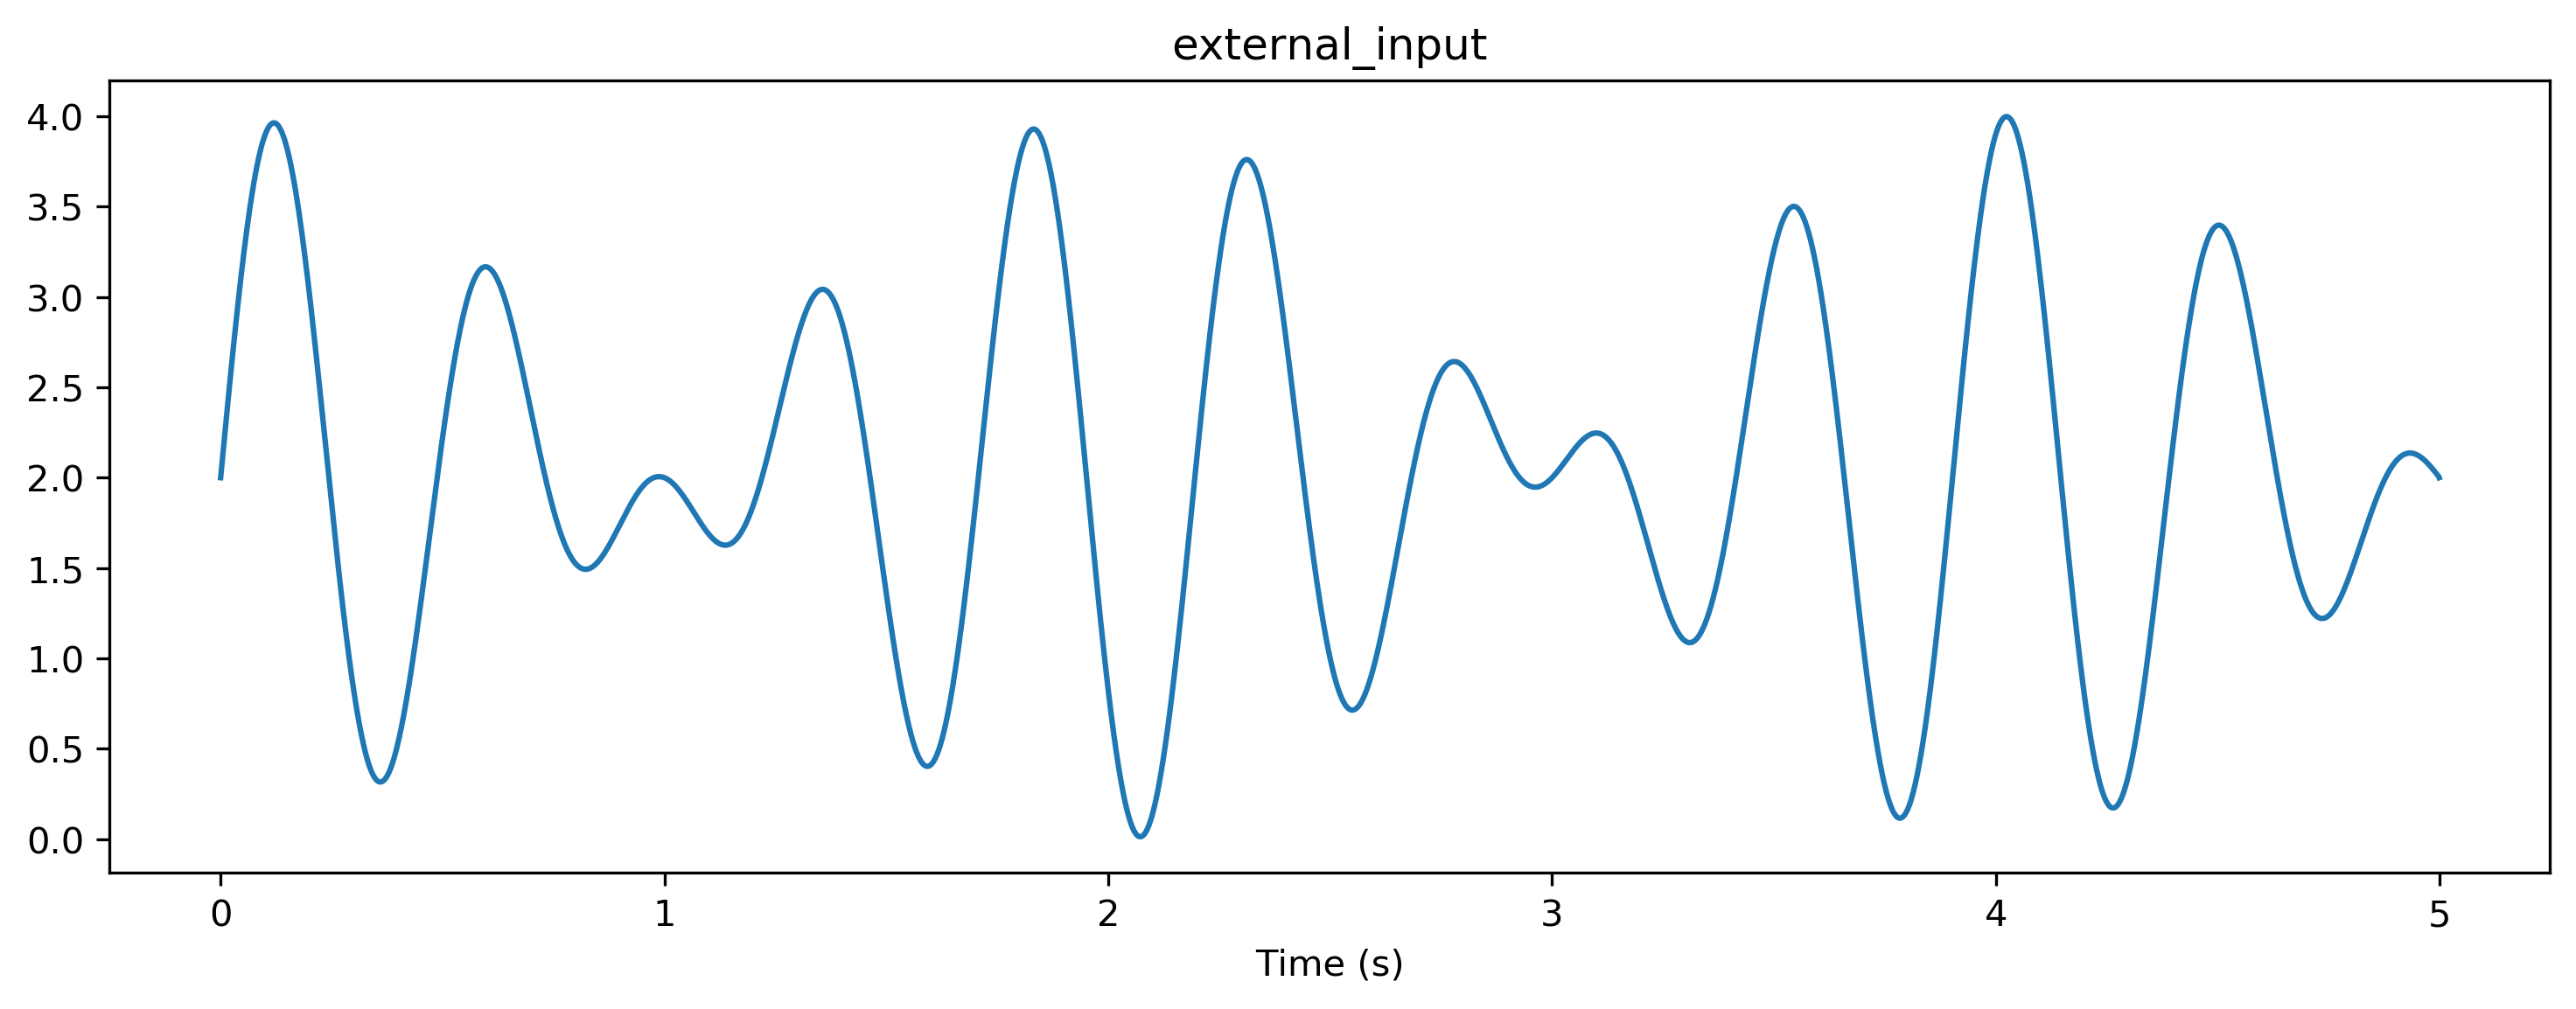

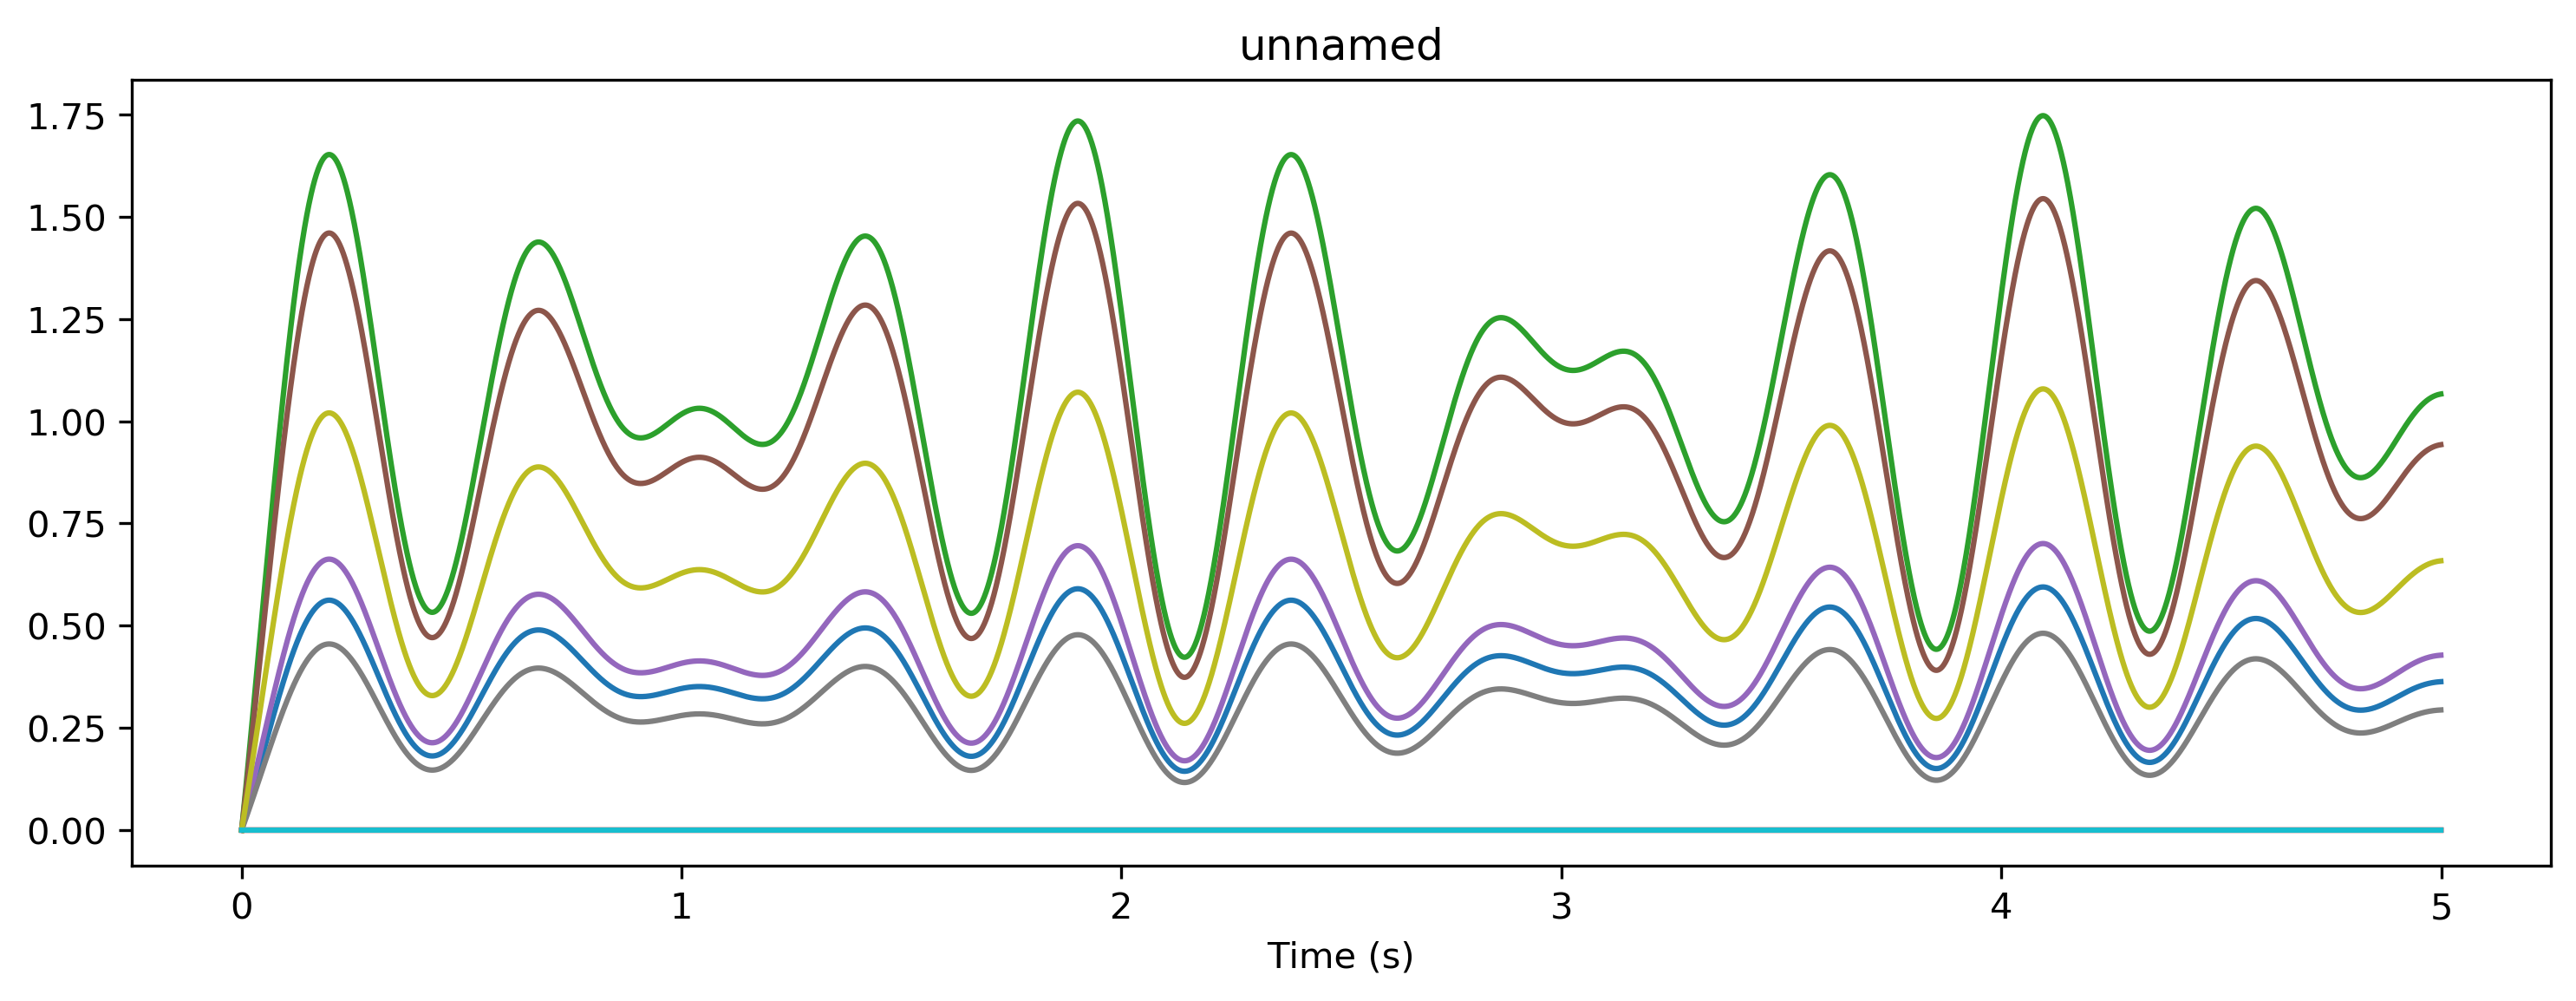

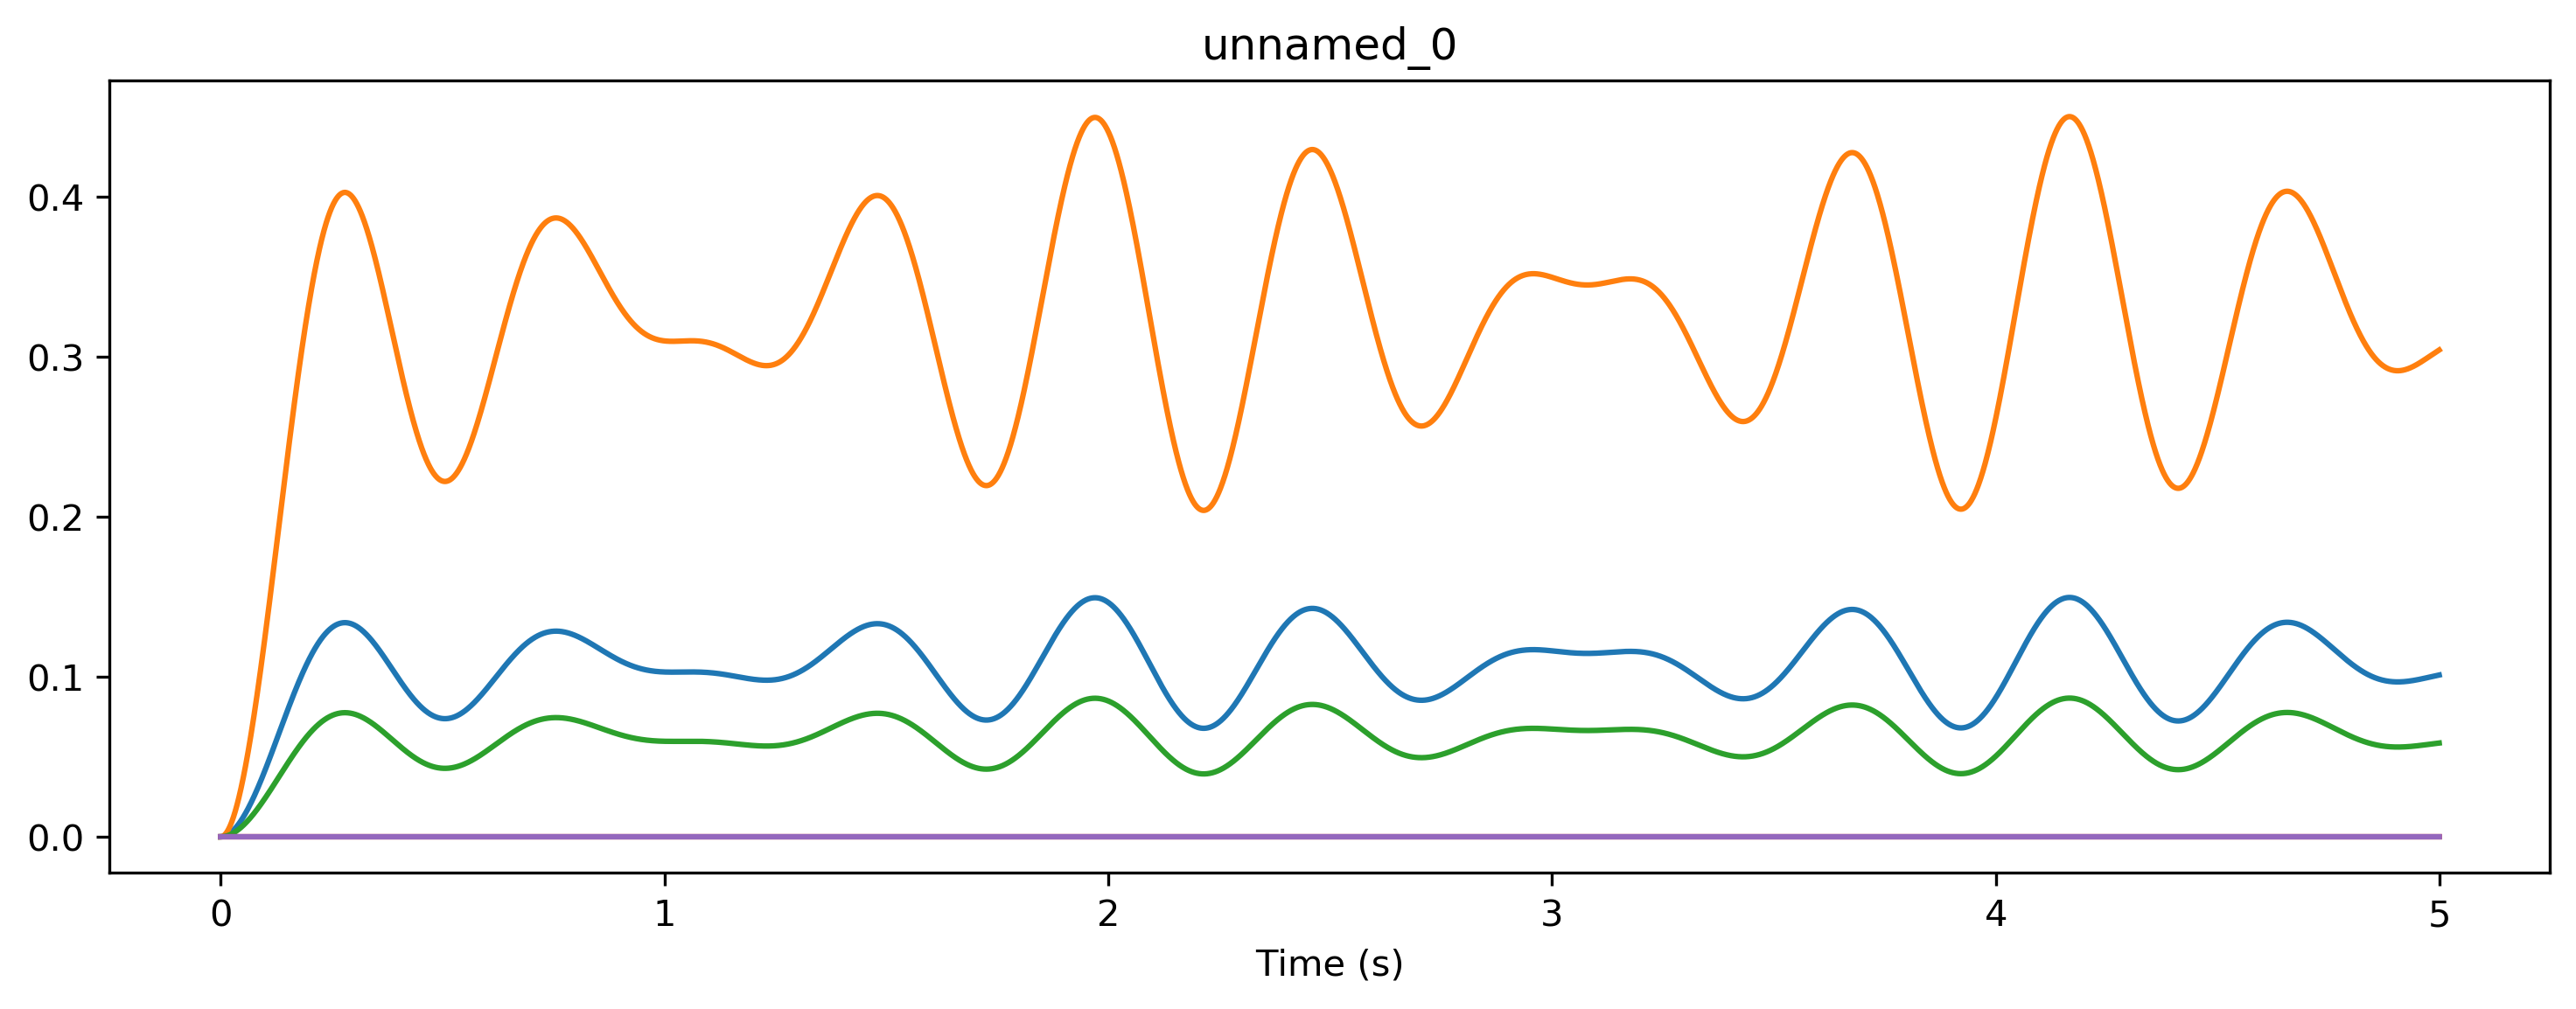

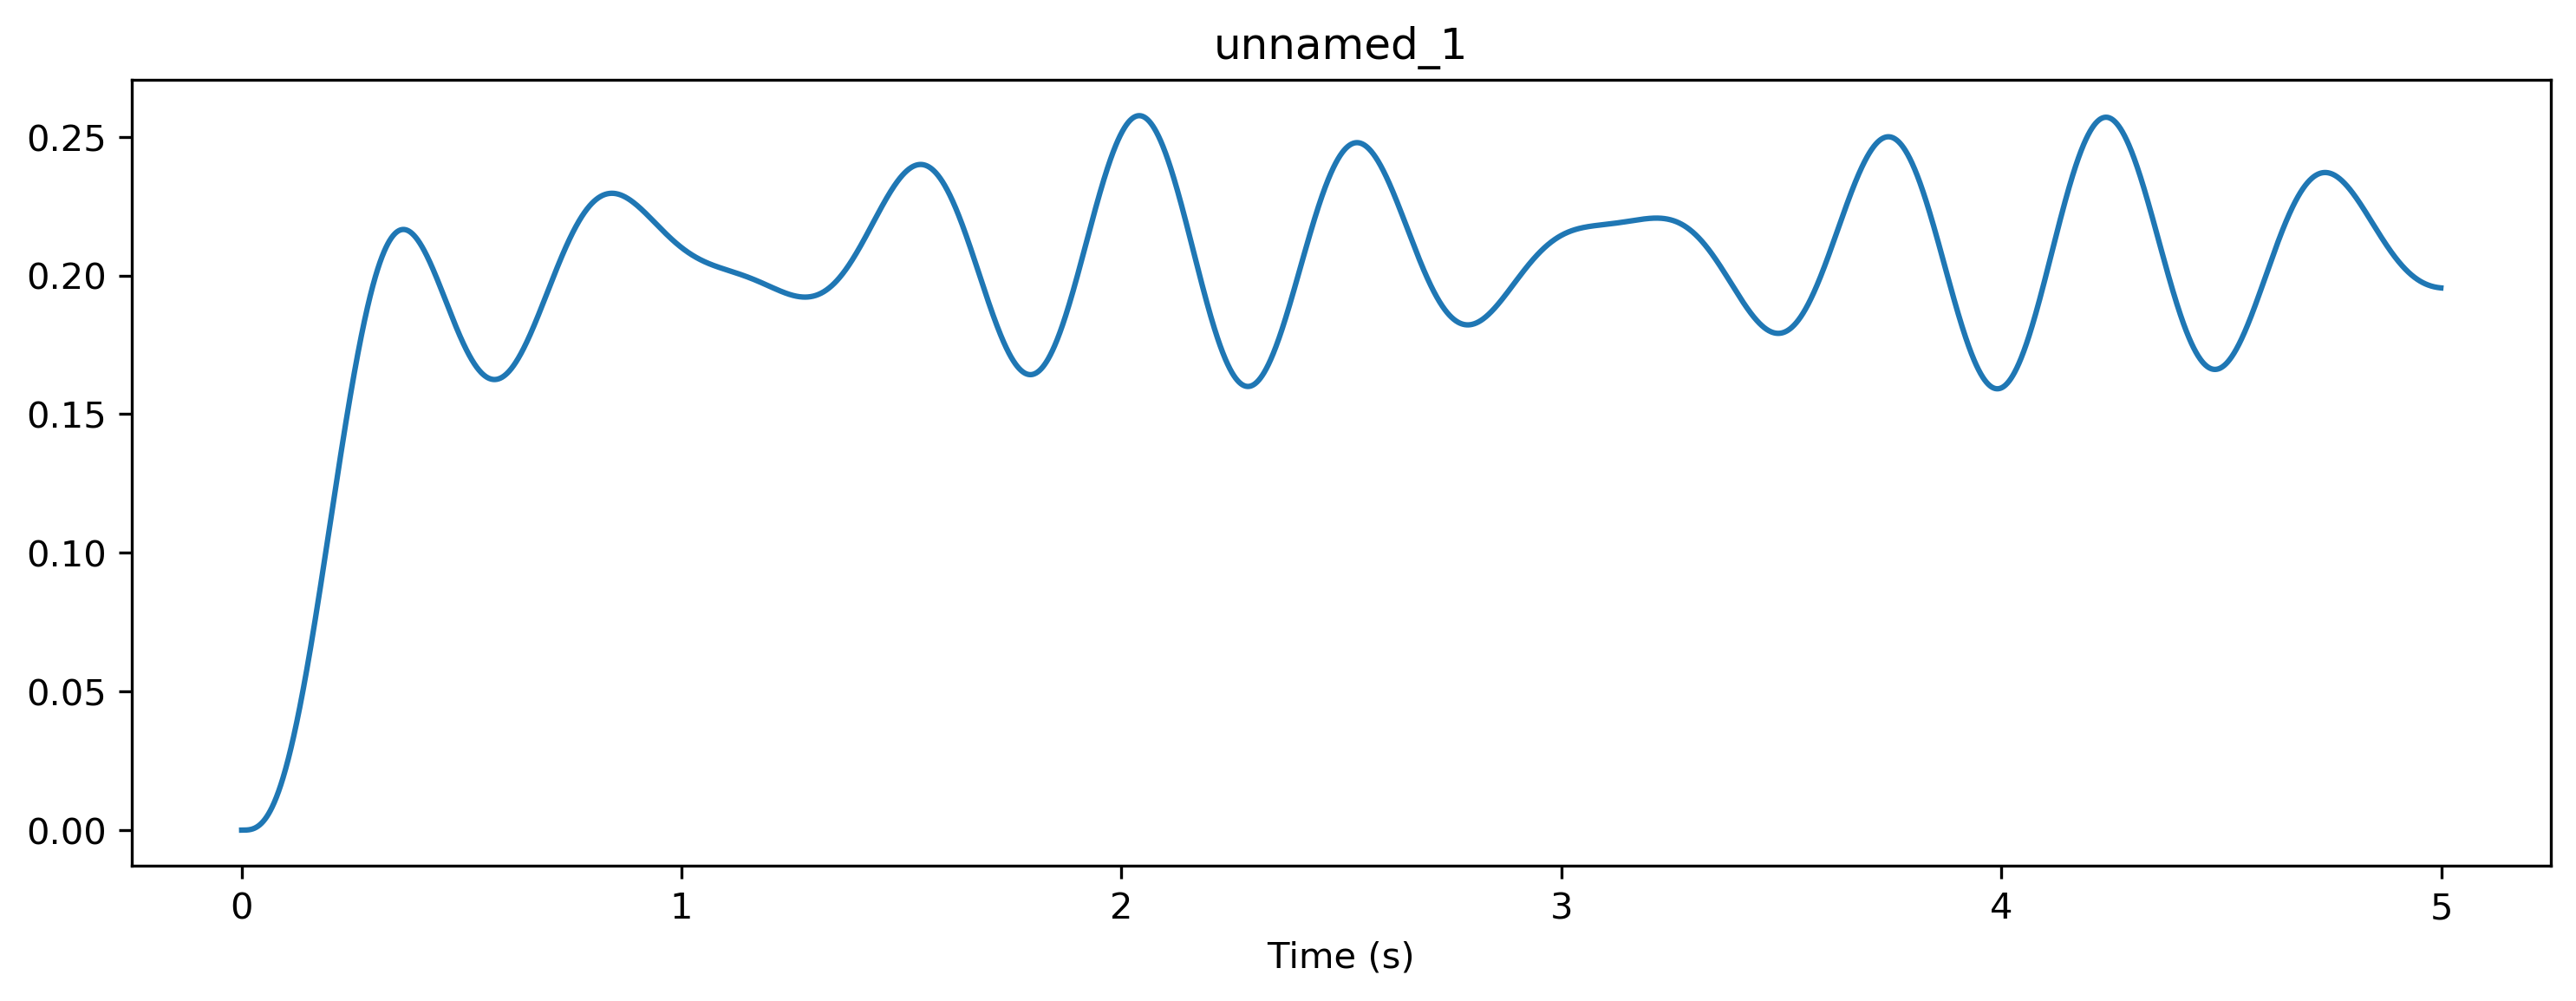

In [8]:
# - Evolve the stack from input to output
d_outputs = stack_ffwd.evolve(ts_sinusoid)

# - Plot each of the layer outputs in turn
for k, out in d_outputs.items():
    plt.figure()
    out.plot()
    plt.title(k)

## Training a stack

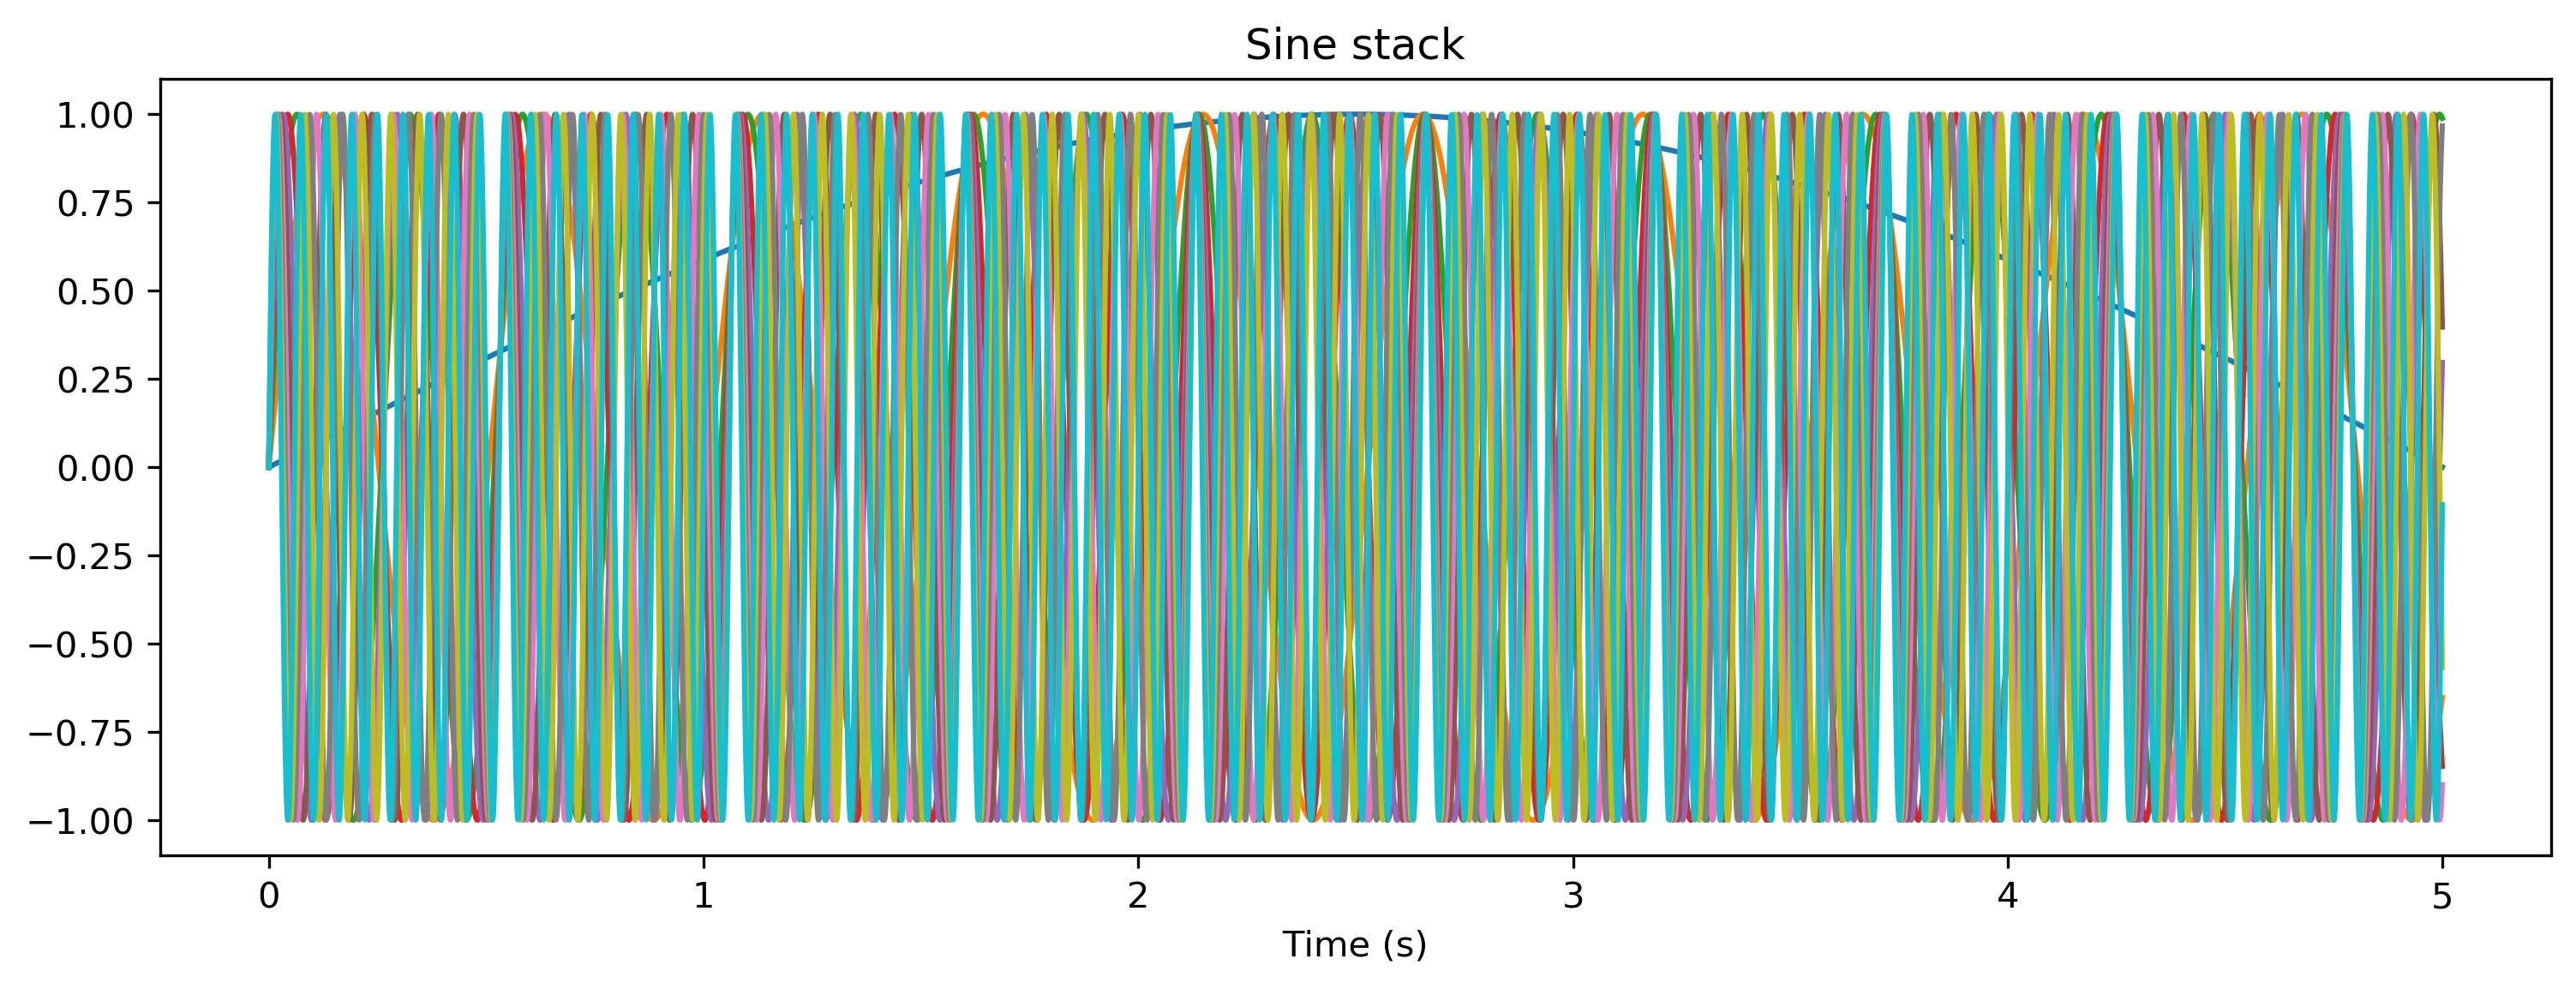

In [9]:
# - Generate a range of sinusoids
num_inputs = 10
ts_input_sines = TSContinuous(
    time_base,
    np.sin(np.atleast_2d(time_base).T * 2 * np.pi * np.atleast_2d(np.linspace(.1, 17, num_inputs))),
    periodic = True, name = 'Sine stack'
)
ts_input_sines.plot();

We also need to re-generate our stack to have the same number of input channels. We'll probably need a larger network for this task, so we'll use the architecture shown below.

In [10]:
Image(filename='images/ffwd_stack_10_100_50_10_1.png', width=225)

In [11]:
# - Define a new network
layer_sizes = [num_inputs, 100, 50, 10, 1]

# - Iterate over layers and construct them into a list
layers = []
for N_in, N_out in zip(layer_sizes[:-1], layer_sizes[1:]):
    # - Generate random parameters for this layer
    weights = np.random.randn(N_in, N_out) / np.sqrt(N_in * N_out)

    # - Build a layer and append it to the list
    layers.append(FFRateEulerJax(weights, tau, bias, dt = dt))
    
# - Build the stack
stack_ffwd = JaxStack(layers)
print(stack_ffwd)

JaxStack object with 4 layers
    FFRateEulerJax object: "unnamed" [10 TSContinuous in -> 100 internal -> 100 TSContinuous out]
    FFRateEulerJax object: "unnamed_0" [100 TSContinuous in -> 50 internal -> 50 TSContinuous out]
    FFRateEulerJax object: "unnamed_1" [50 TSContinuous in -> 10 internal -> 10 TSContinuous out]
    FFRateEulerJax object: "unnamed_2" [10 TSContinuous in -> 1 internal -> 1 TSContinuous out]


Text(0.5, 1.0, 'Training loss')

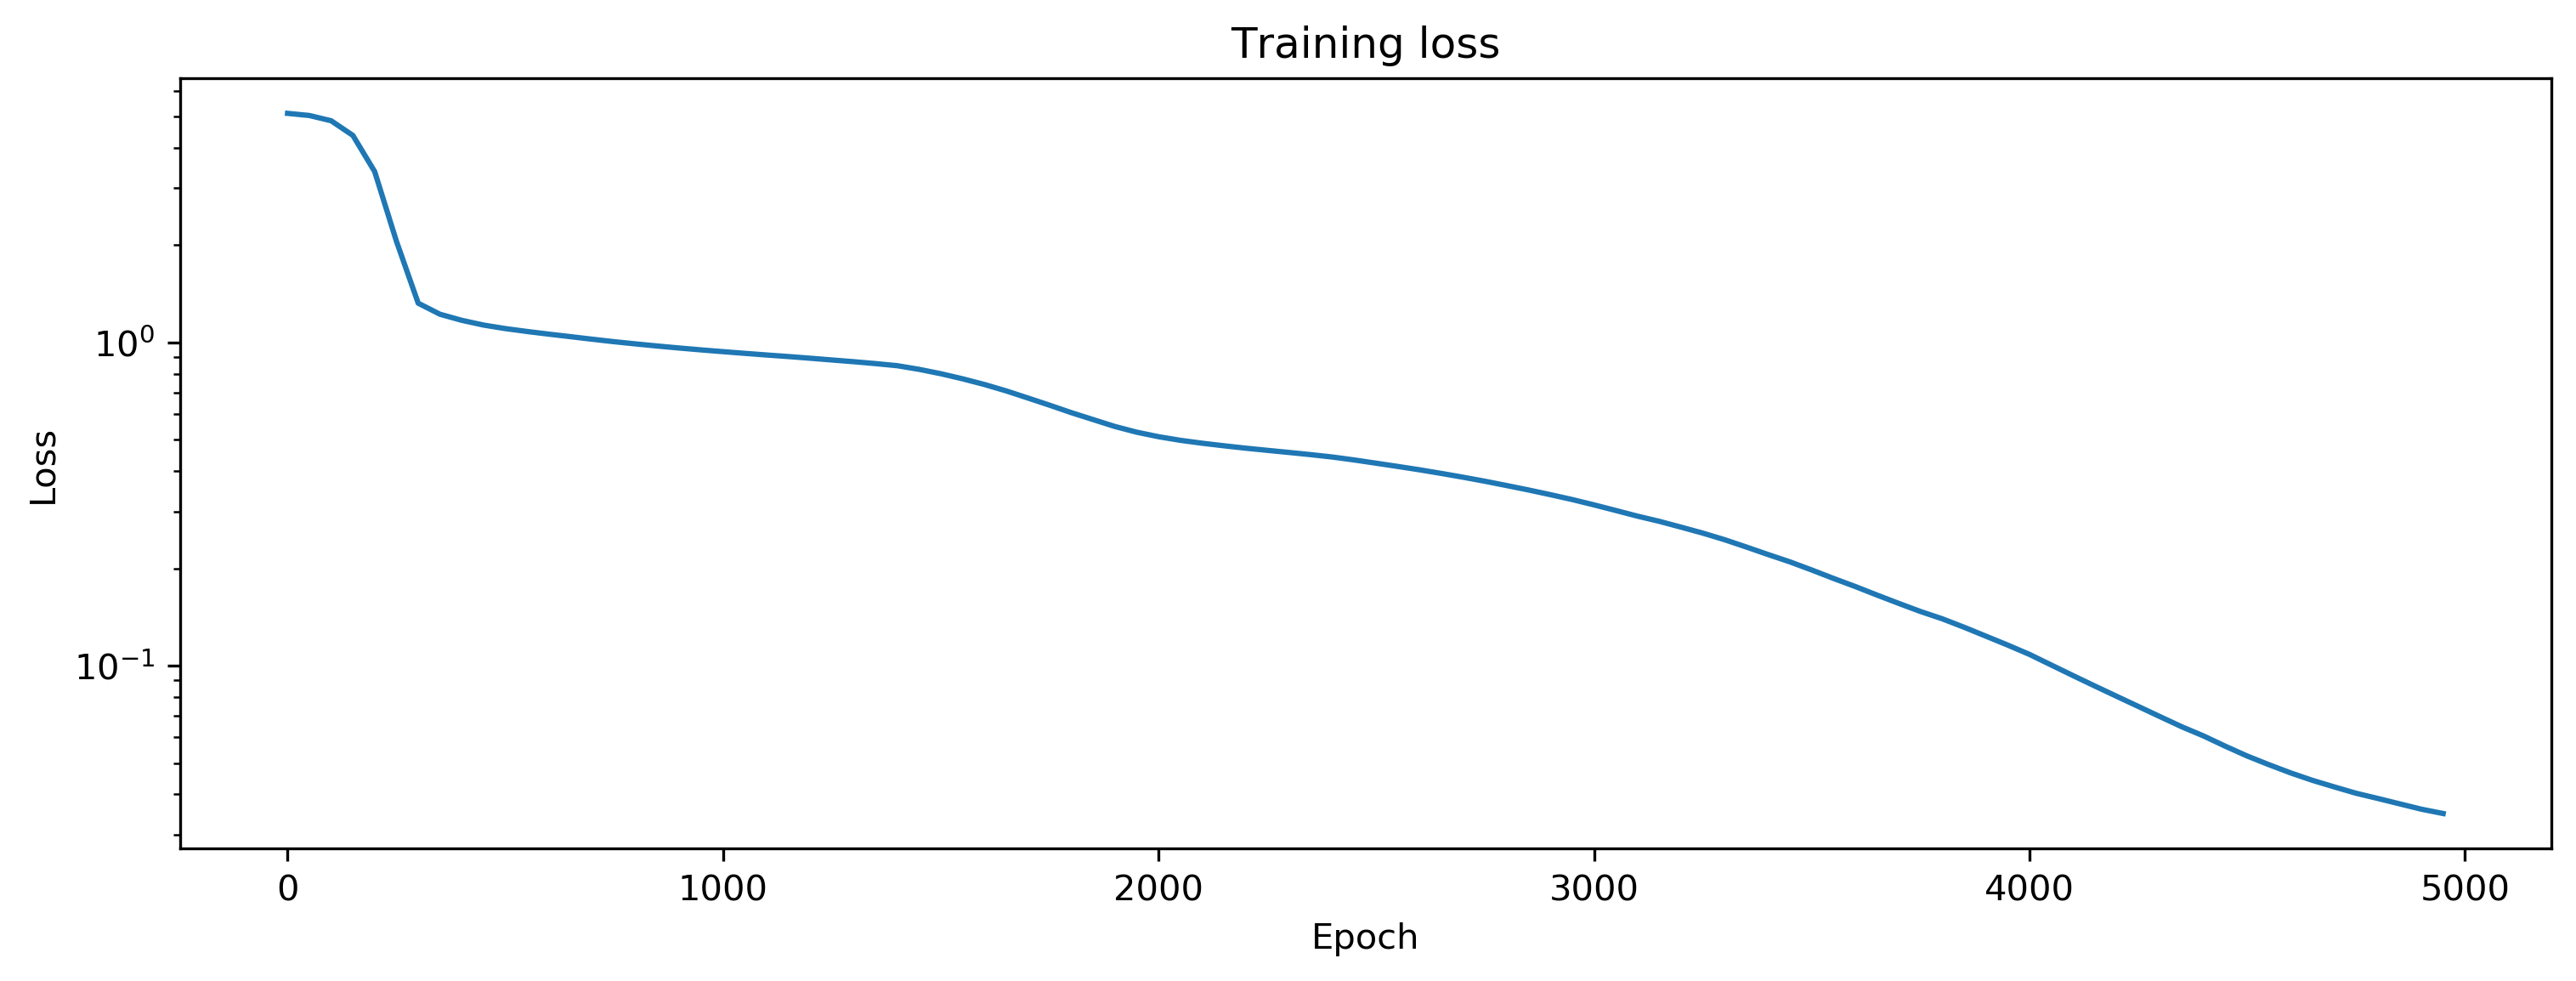

In [12]:
# - Set the number of total training trials
num_trials = 5000

# - Retain the loss values over epochs
loss_i_t = []
loss_t = []

# - Loop over trials
with tqdm(range(num_trials)) as t:
    for i in t:
        # - Randomise the state of all layers before the start of the trial
        stack_ffwd.reset_state()
        
        # - Perform one trial of stochastic back-propagation through time
        l, g, o = stack_ffwd.train_output_target(ts_input_sines, ts_sinusoid, is_first = i == 1)
        
        # - Keep the loss values only every 50 trials (since l() takes time to compute)
        if i % 50 == 0:
            loss = l()
            loss_i_t.append(i)
            loss_t.append(loss)
            t.set_postfix({'loss': loss})

# - Plot the loss over epochs
plt.plot(loss_i_t, loss_t)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')

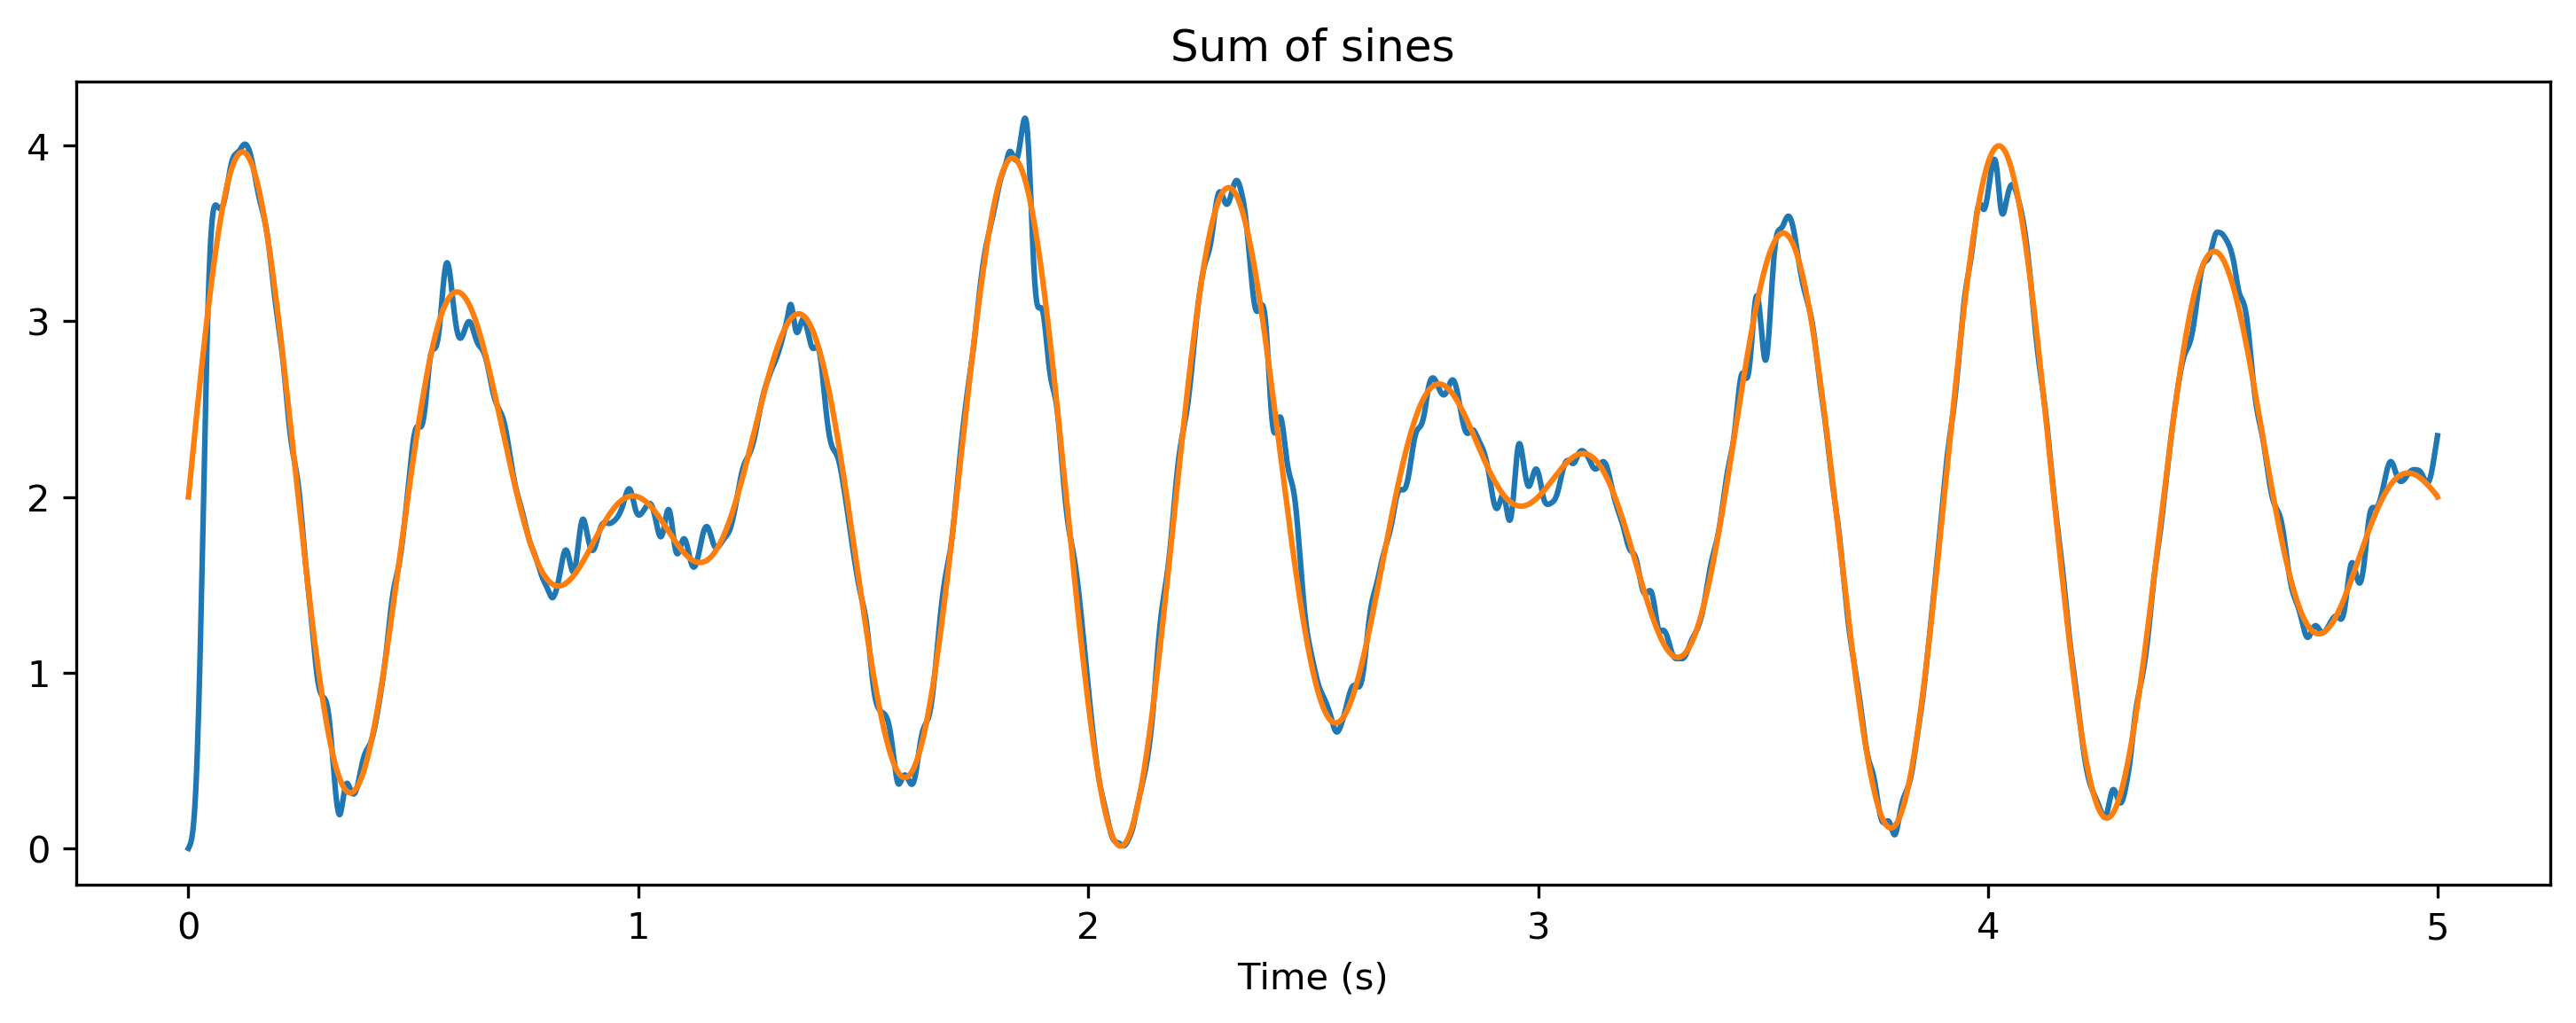

In [13]:
stack_ffwd.reset_state()
ts_output = stack_ffwd.evolve(ts_input_sines)
ts_output['unnamed_2'].plot()
ts_sinusoid.plot(ts_output['unnamed_2'].times);

## Training a stack of recurrent layers

In [14]:
Image(filename='images/rec_stack_10_100_50_50_10_10_1.png', width=600)

In [15]:
# - Specify the layer sizes and FF channel sizes
FF_channel_sizes = [num_inputs, 50, 10, 1]
layer_sizes = [100, 10, 10]

# - Build each layer in turn
layers = []
for N_in, N, N_out in zip(FF_channel_sizes[:-1], layer_sizes, FF_channel_sizes[1:]):
    # - Generate initial parameters for this layer
    w_in = np.random.randn(N_in, N) / np.sqrt(N_in * N)
    w_rec = np.random.randn(N, N) / np.sqrt(N)
    w_out = np.random.randn(N, N_out) / np.sqrt(N * N_out)

    # - Build the layer and store it
    layers.append(RecRateEulerJax_IO(w_in, w_rec, w_out, tau, bias, dt = dt))
    
# - Build the stack
stack_rec = JaxStack(layers)
print(stack_rec)

JaxStack object with 3 layers
    RecRateEulerJax_IO object: "unnamed" [10 TSContinuous in -> 100 internal -> 50 TSContinuous out]
    RecRateEulerJax_IO object: "unnamed_0" [50 TSContinuous in -> 10 internal -> 10 TSContinuous out]
    RecRateEulerJax_IO object: "unnamed_1" [10 TSContinuous in -> 10 internal -> 1 TSContinuous out]


Now we can train the network using the same approach as for the feed-forward stack.

Text(0.5, 1.0, 'Training loss')

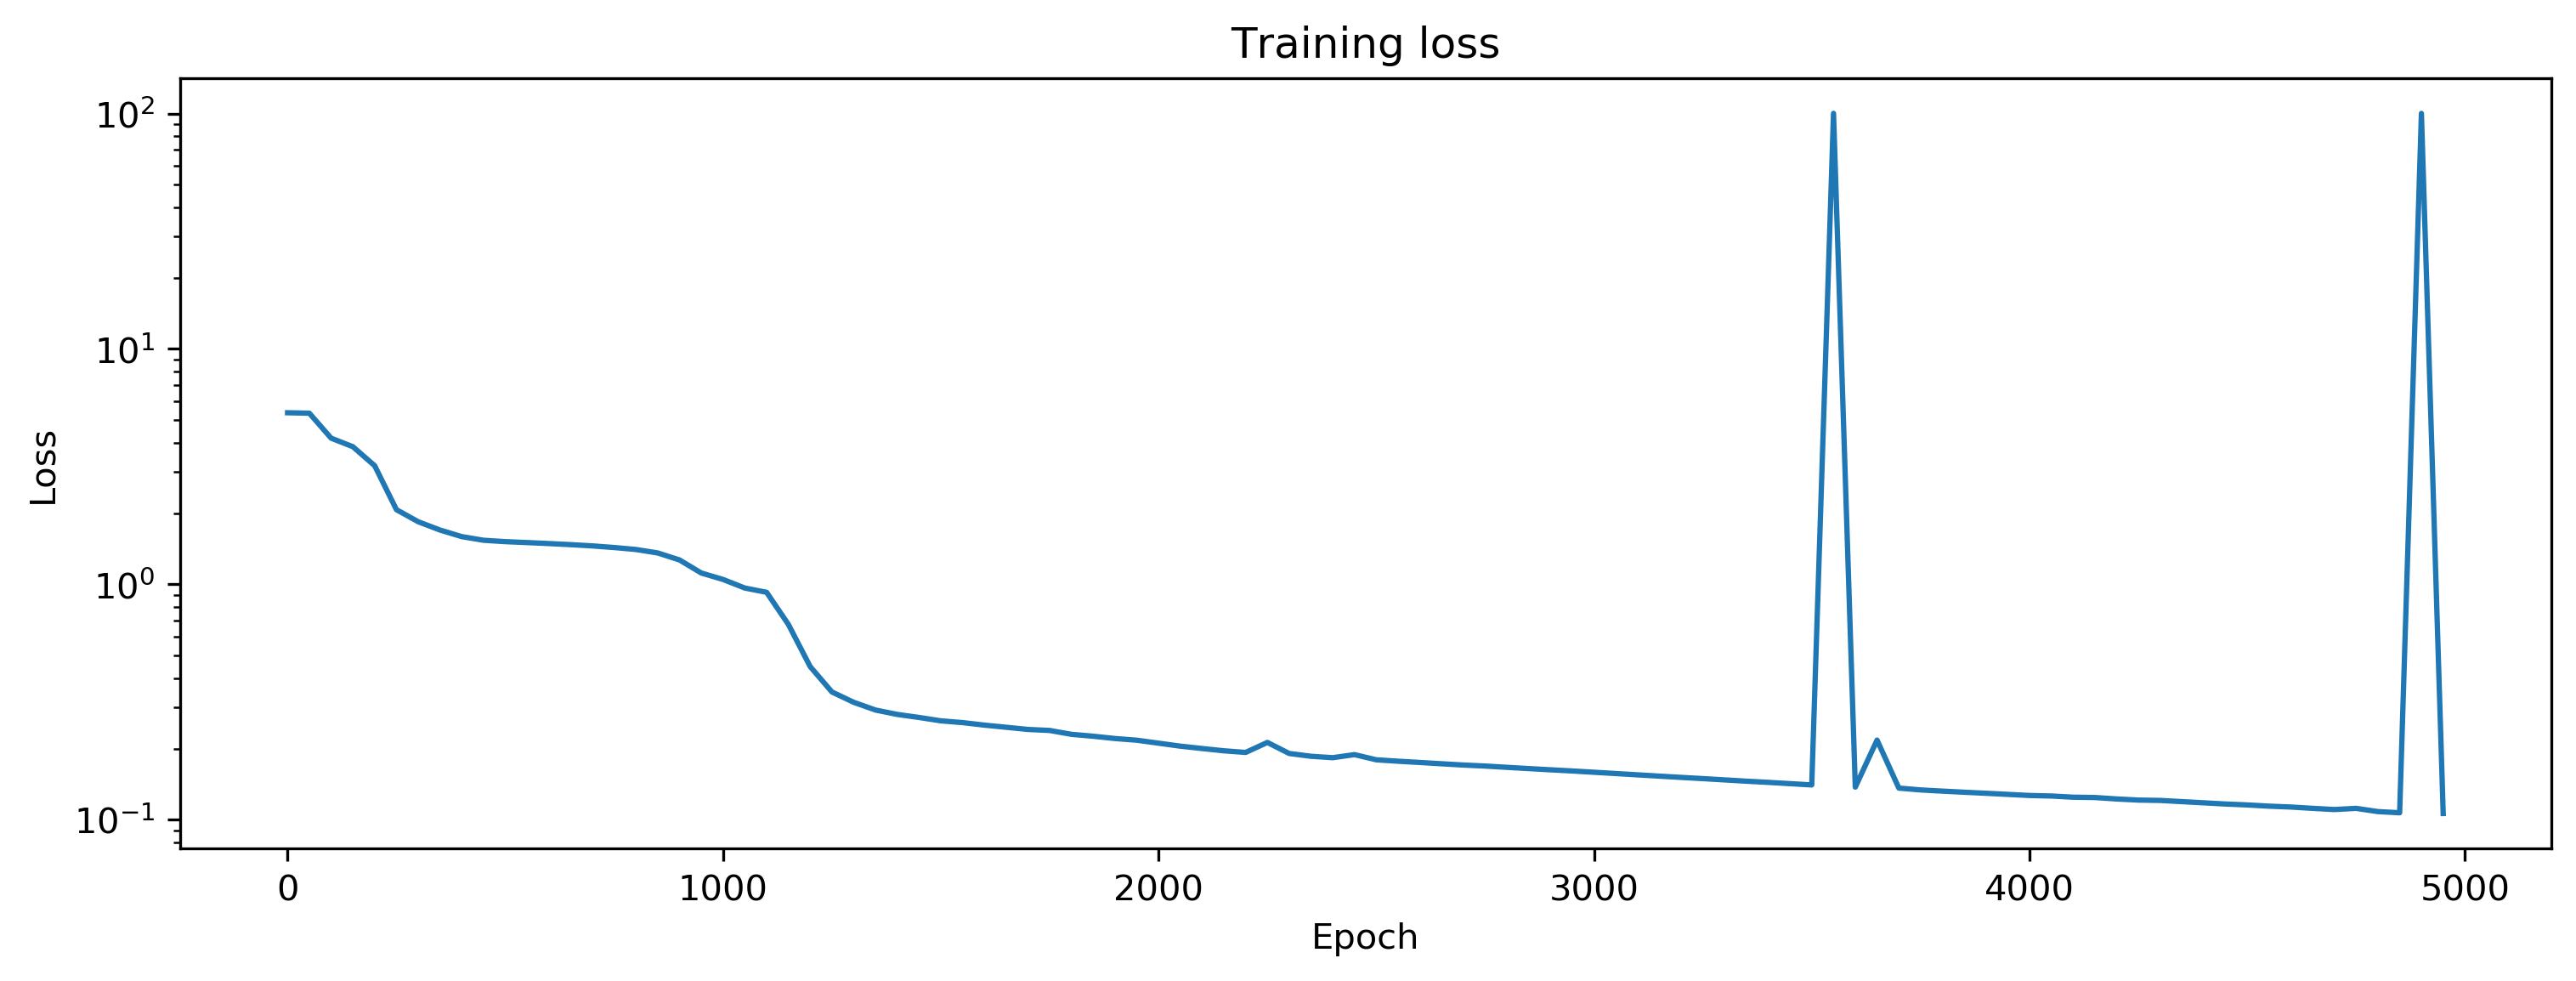

In [16]:
# - Set the number of total training trials
num_trials = 5000

# - Retain the loss values over epochs
loss_i_t = []
loss_t = []

# - Loop over trials
with tqdm(range(num_trials)) as t:
    for i in t:
        # - Randomise the state of all layers before the start of the trial
        stack_rec.reset_state()
        
        # - Perform one trial of stochastic back-propagation through time
        l, g, o = stack_rec.train_output_target(ts_input_sines, ts_sinusoid) #, is_first = i == 1)
        
        # - Keep the loss values only every 50 trials (since l() takes time to compute)
        if i % 50 == 0:
            loss = l()
            loss_i_t.append(i)
            loss_t.append(loss)
            t.set_postfix({'loss': loss})

# - Plot the loss over epochs
plt.plot(loss_i_t, loss_t)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')

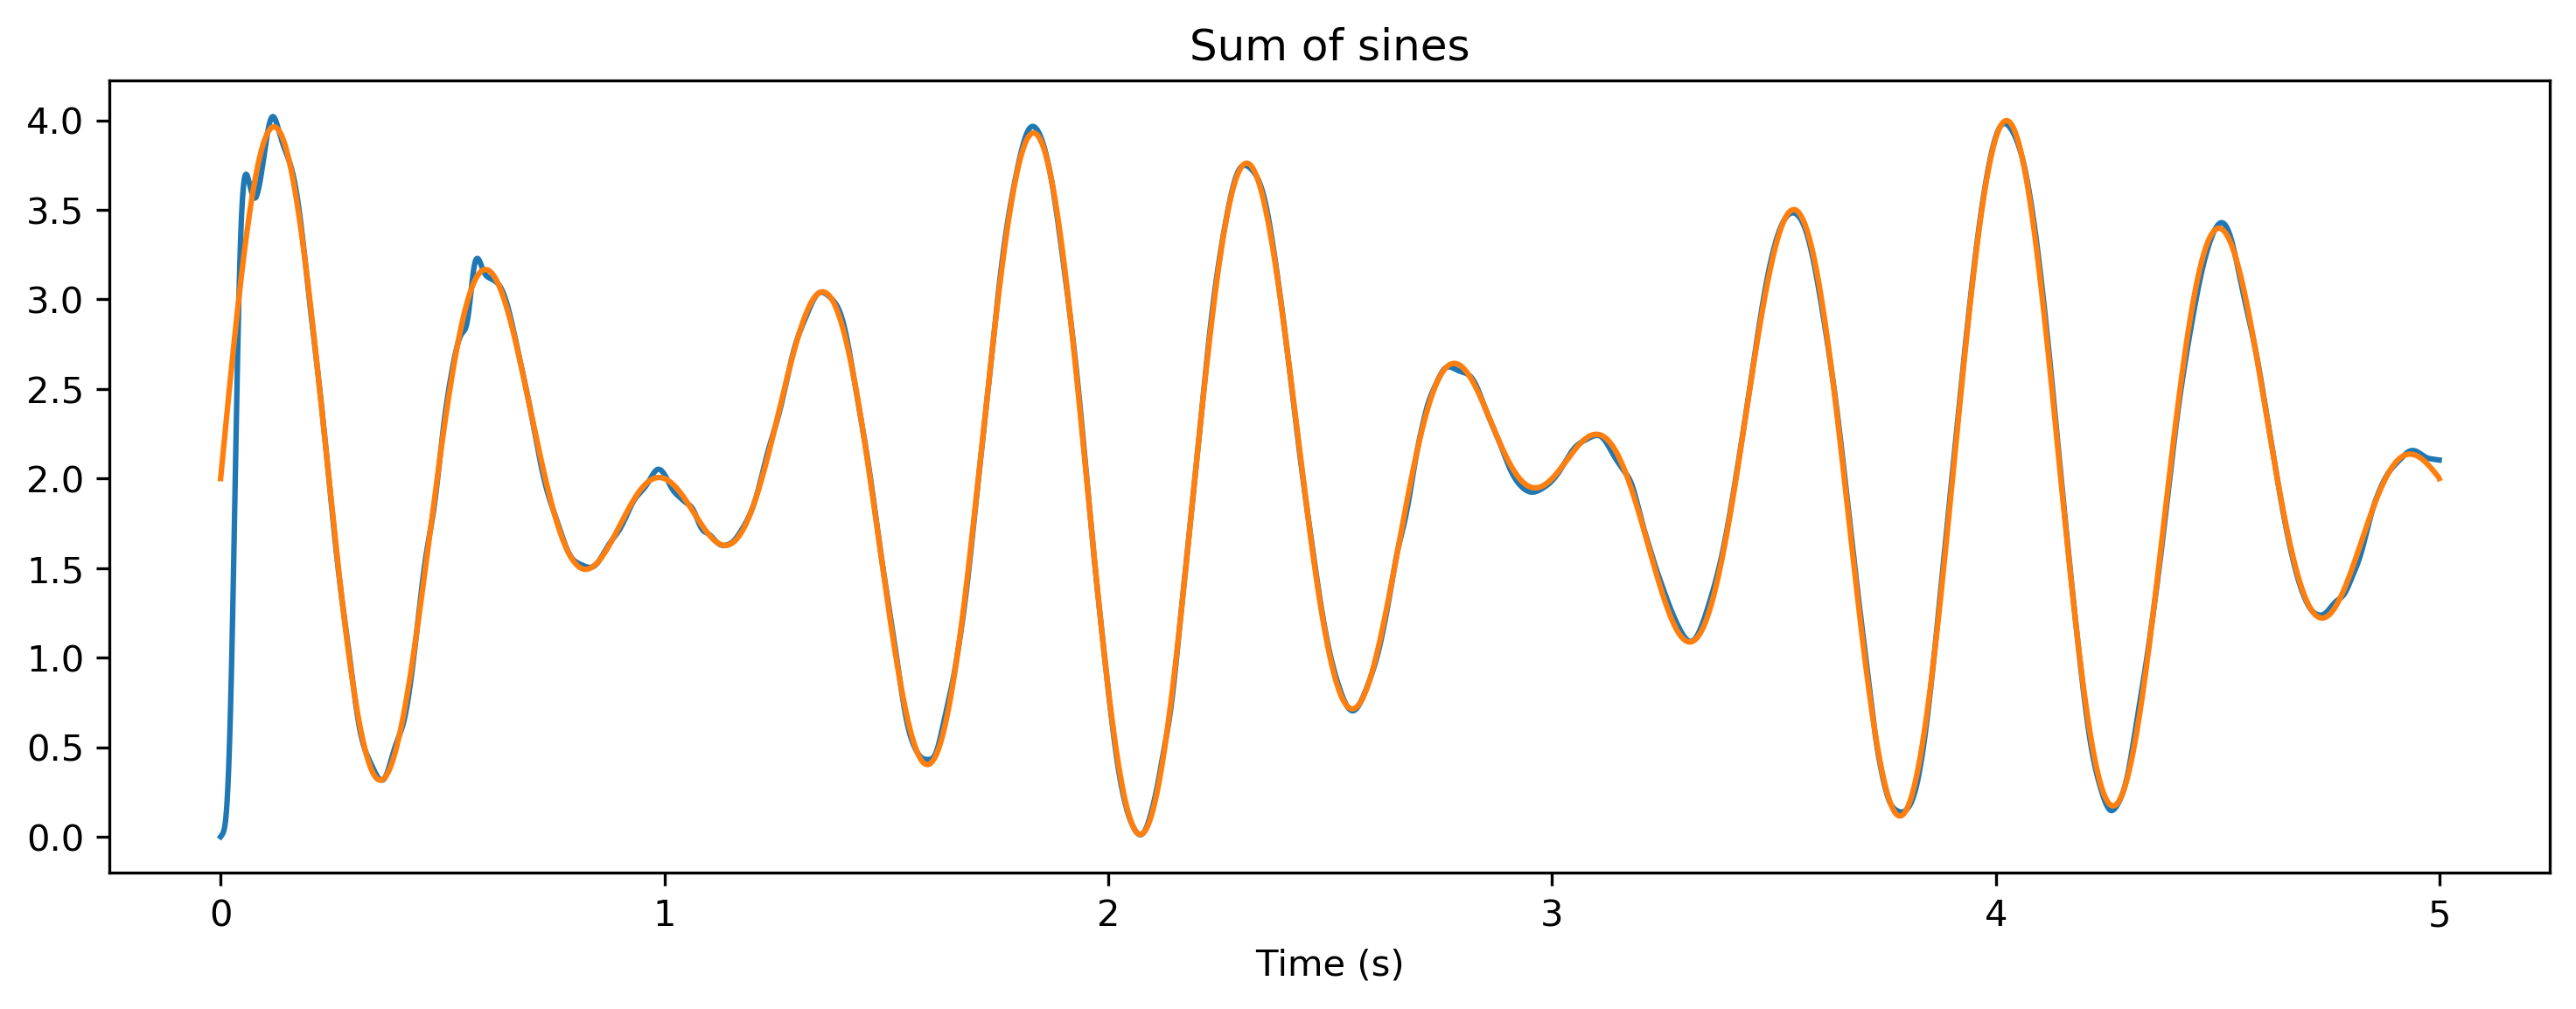

In [17]:
stack_rec.reset_state()
ts_output = stack_rec.evolve(ts_input_sines)
ts_output['unnamed_1'].plot()
ts_sinusoid.plot(ts_output['unnamed_1'].times);

## Further reading